## A NMC/Gr parameterisation example using PyBOP

This notebook introduces a synthetic re-parameterisation of the single-particle model with corrupted observations. To start, we import the PyBOP package for parameterisation and the PyBaMM package to generate the initial synethic data,

In [1]:
%pip install --upgrade pip ipywidgets pybamm -q
%pip install git+https://github.com/pybop-team/PyBOP.git@develop -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.7/423.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.9/284.9 kB 15.8 MB/

Next, we import the added packages plus any additional dependencies,

In [21]:
import pybop
import pybamm
import matplotlib.pyplot as plt
import numpy as np

## Generate Synthetic Data

We need to generate the synthetic data required for later reparameterisation. To do this we will run the PyBaMM forward model and store the generated data. This will be integrated into PyBOP in a future release for fast synthetic generation. For now, we define the PyBaMM model with a default parameter set,

In [22]:
synthetic_model = pybamm.lithium_ion.SPM()
params = synthetic_model.default_parameter_values

We can now modify individual parameters with the bespoke values and run the simulation.

In [23]:
params.update(
    {
        "Negative electrode active material volume fraction": 0.52,
        "Positive electrode active material volume fraction": 0.63,
    }
)

Define the experiment and run the forward model to capture the synthetic data.

In [24]:
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1C for 15 minutes (1 second period)",
            "Rest for 2 minutes (1 second period)",
            "Charge at 1C for 15 minutes (1 second period)",
            "Rest for 2 minutes (1 second period)",
        ),
    ]
    * 2
)
sim = pybamm.Simulation(synthetic_model, experiment=experiment, parameter_values=params)
synthetic_sol = sim.solve()

Plot the synthetic data,

interactive(children=(FloatSlider(value=0.0, description='t', max=1.1333333333333333, step=0.01133333333333333…

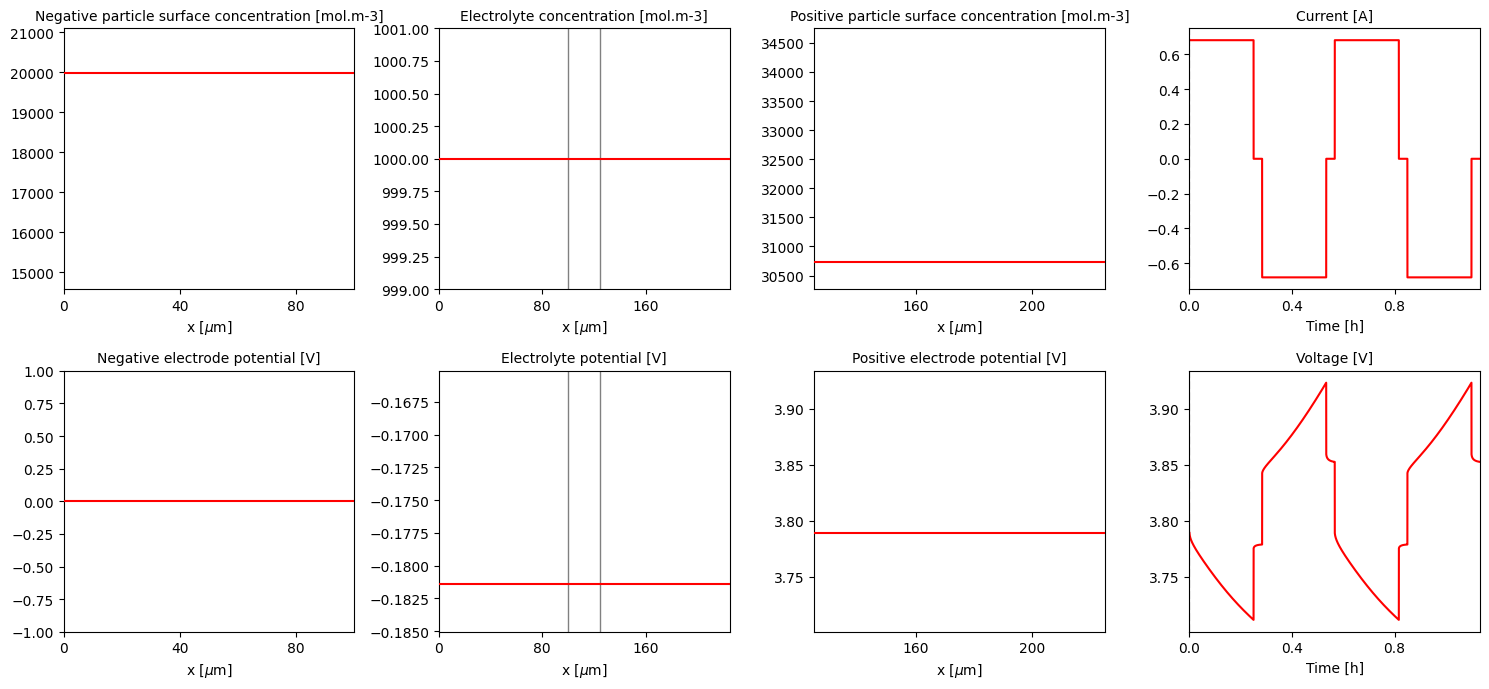

In [25]:
sim.plot()

Now, let's corrupt the synthetic data with 1mV of gaussian noise centered around zero,

In [26]:
corrupt_V = synthetic_sol["Terminal voltage [V]"].data
corrupt_V += np.random.normal(0, 0.001, len(corrupt_V))

## Identify the Parameters

Now, to blind fit the synthetic parameters we need to define the observation variables as well as update the forward model to be of PyBOP type (This composes PyBaMM's model class). For the observed voltage variable, we used the newly corrupted voltage array,

In [64]:
pyb_model = pybop.lithium_ion.SPM()
dataset = [
    pybop.Dataset("Time [s]", synthetic_sol["Time [s]"].data),
    pybop.Dataset("Current function [A]", synthetic_sol["Current [A]"].data),
    pybop.Dataset("Terminal voltage [V]", corrupt_V),
]

Next, we define the targeted forward model parameters for estimation. Furthermore, PyBOP provides functionality to define a prior for the parameters. The initial parameters values used in the estimiation will be randomly drawn from the prior distribution.

In [65]:
parameters = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.5, 0.02),
        bounds=[0.48, 0.625],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.65, 0.02),
        bounds=[0.525, 0.75],
    ),
]

We can now define the fitting signal, a problem (which combines the model with the dataset) and construct a cost function.

In [66]:
# Define the cost to optimise
signal = "Terminal voltage [V]"
problem = pybop.Problem(parameters, dataset, model=pyb_model, signal=signal)
cost = pybop.RootMeanSquaredError(problem)

Let's construct PyBOP's optimisation class. This class provides the methods needed to fit the forward model. For this example, we use a root-mean square cost function with the BOBYQA algorithm implemented in NLOpt.

In [67]:
parameterisation = pybop.Optimisation(
    cost=cost,
    optimiser=pybop.NLoptOptimize,
)

Finally, we run the estimation algorithm.

In [68]:
x, final_cost = parameterisation.run()

Let's view the identified parameters:

In [69]:
x

array([0.48367449, 0.63380314])

## Plotting

First, run the SPM forward model with the estimated parameters,

In [70]:
params.update(
    {
        "Negative electrode active material volume fraction": x[0],
        "Positive electrode active material volume fraction": x[1],
    }
)
optsol = sim.solve()["Terminal voltage [V]"].data

Now, we plot the estimated forward model against the corrupted synthetic observation,

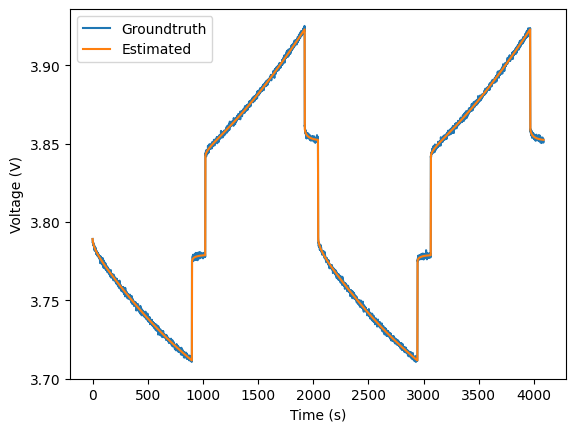

In [71]:
plt.plot(corrupt_V, label="Groundtruth")
plt.plot(optsol, label="Estimated")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()